In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import torch
from pathlib import Path
import sys
import time
sys.path.append("..")

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from falkon.kernels import GaussianKernel
from falkon import FalkonOptions
from nyskoop.data.lorenz import Lorenz63
from experiment_helpers import *

In [3]:
set_matplotlib_rc(18, 20, 22)

In [4]:
def gen_l63_fulldata(n_train: int, n_test: int, num_test_sets: int, max_q: int, **kwargs):
    lorenz63_dset = Lorenz63(1, 1, 1, sigma=10, rho=28, beta=8/3, **kwargs)
    n_steps = calc_lagged_num_steps(n_train, n_test, num_test_sets, max_q)
    full_data = lorenz63_dset.solve(n_steps)
    full_data = torch.from_numpy(full_data)
    return full_data

In [5]:
def calc_est_error(X_train, Y_train, all_test_sets, kind, **kwargs):
    t_start = time.time()
    est = train_est(X_train, Y_train, kind=kind, **kwargs)
    t_end = time.time()
    err, std = nrmse(est, all_test_sets, variable=0)
    return err.item(), std.item(), t_end - t_start

In [115]:
n_train, n_test = 10_000, 10_000
num_test_sets = 5
l63_version = 'normal'
max_q = 400
q_step = 5
dt = 0.01
sigma = 3.5
num_components = 50
dtype = torch.float64
M = 1000

full_data = gen_l63_fulldata(
    n_train, n_test, num_test_sets, max_q=max_q, dt=dt, burnin=5, l63_version=l63_version)

In [151]:
opt = FalkonOptions(use_cpu=True)
output_path = Path("outputs/skaf_comparison")
output_path.mkdir(exist_ok=True, parents=True)

model_params = {
    "pcr": {
        "num_components": num_components,
        "kernel": GaussianKernel(sigma, opt=opt),
        "M": M,
        "svd_solver": "full",
    },
    "fastpcr": {
        "num_components": num_components,
        "kernel": GaussianKernel(sigma, opt=opt),
        "M": M,
        "n_iter": 1,
        "oversampling": 2,
    },
    "rrr": {
        "num_components": num_components,
        "kernel": GaussianKernel(sigma, opt=opt),
        "M": M,
        "penalty": 1e-4,
    },
    "krr": {
        "kernel": GaussianKernel(sigma, opt=opt),
        "M": M,
        "penalty": 5e-3,
    },
    "fastrrr": {
        "num_components": num_components,
        "kernel": GaussianKernel(sigma, opt=opt),
        "M": M,
        "penalty": 1e-4,
        "n_iter": 1,
        "oversampling": 2,
    },
    "kaf_scalable": {
        "sigma": sigma,
        "approx_rank": num_components,
        "num_features": int(math.sqrt(n_train) * math.log(n_train)),
        "block_size": 20_000,
    }
}
def name_from_model(model, model_params):
    params = model_params[model]
    if "kernel" in params:
        sigma = params["kernel"].sigma.item()
    else:
        sigma = params["sigma"]
    if "num_components" in params:
        rank = params["num_components"]
    elif "approx_rank" in params:
        rank = params["approx_rank"]
    else:
        rank = None
    name = f"{model}_s{sigma}_r{rank}"
    if "M" in params:
        name += f"_M{params['M']}"
    if "penalty" in params:
        name += f"_pen{params['penalty']}"
    if "block_size" in params:
        name += f"_bs{params['block_size']}"
    return f"{name}"

### Run experiment

In [152]:
qs = np.arange(1, max_q, q_step)

for model in ["krr"]:#"pcr", "fastpcr", "rrr", "fastrrr", "kaf_scalable"]:
    df_save_path = output_path / f"{name_from_model(model, model_params)}.csv"
    print(f"Will save df to {df_save_path}")
    df_dict = []
    for q in tqdm(qs, desc=f"Varying q: {model.upper()}"):
        X_train, Y_train, all_test_sets = gen_lagged(
            full_data, n_train, n_test, num_test_sets, q, dtype=dtype
        )
        err, std, t_elapsed = calc_est_error(
            X_train, Y_train, all_test_sets, kind=model, **model_params[model]
        )
        df_dict.append(
            dict(q=q, err=err, std=std, time=t_elapsed, kind=model) | model_params[model]
        )
    qerr_df = pd.DataFrame.from_dict(df_dict)

    df_save_path.parent.mkdir(parents=True, exist_ok=True)
    qerr_df.to_csv(df_save_path, index=False)
    print(f"Saved df to {df_save_path}")

Will save df to outputs/skaf_comparison/krr_s3.5_rNone_M1000_pen0.005.csv


Varying q: KRR: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:21<00:00,  3.73it/s]

Saved df to outputs/skaf_comparison/krr_s3.5_rNone_M1000_pen0.005.csv


### Plot

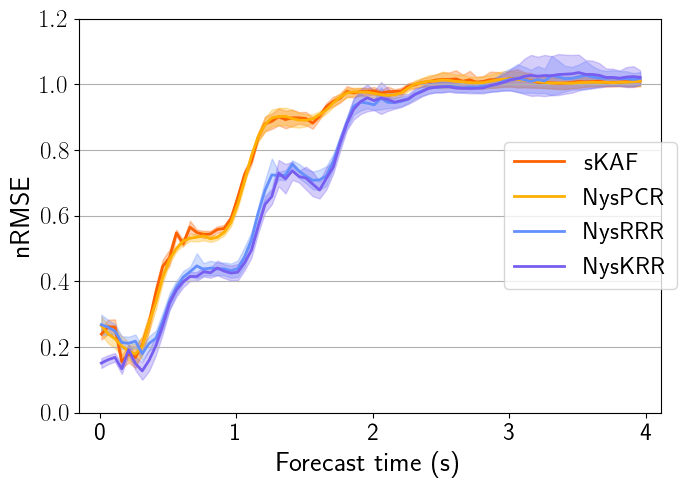

In [154]:
plot_df_paths = [
#     [output_path / "kaf_scalable_s7_r50.csv", "sKAF", IBM_COLORS[0]],
#     [output_path / "rrr_s7.0_r10_M250_pen0.csv", "NysRRR", IBM_COLORS[1]],
#     [output_path / "fastrrr_s7.0_r10_M250_pen1e-09.csv", "FAST NysRRR", IBM_COLORS[2]],
#     [output_path / "fastpcr_s7.0_r50_M2000.csv", "FastPCR", IBM_COLORS[0]],
#     [output_path / "pcr_s7.0_r50_M1000.csv", "NysPCR", IBM_COLORS[1]],
#     [output_path / "rrr_s7.0_r10_M250_pen0.csv", "NysRRR", IBM_COLORS[2]],
#     [output_path / "rrr_s7.0_r10_M250_pen1e-09.csv", "FastRRR", IBM_COLORS[3]],
    [output_path / "kaf_scalable_s3.5_r50.csv", "sKAF", IBM_COLORS[0]],
    [output_path / "pcr_s3.5_r50_M250.csv", "NysPCR", IBM_COLORS[2]],
#     [output_path / "kaf_scalable_s3.5_r50_bs20000.csv", "sKAF 20k", IBM_COLORS[1]],
#     [output_path / "rrr_s3.5_r50_M250_pen0.0001.csv", "NysRRR(M=250)", IBM_COLORS[1]],  #xx
    [output_path / "rrr_s3.5_r50_M250_pen0.0001.csv", "NysRRR", IBM_COLORS[1]],  #xx
    [output_path / "krr_s3.5_rNone_M250_pen0.0001.csv", "NysKRR", IBM_COLORS[3]],
#     [output_path / "fastpcr_s3.5_r50_M250.csv", "FastPCR", IBM_COLORS[1]],
#     [output_path / "fastrrr_s3.5_r50_M250_pen1e-09.csv", "FastRRR", IBM_COLORS[3]],
]
fig = plot_stuffs(plot_df_paths, False)
fig.tight_layout()
fig.savefig(output_path / "m250_r50_wkrr.png", dpi=300)

In [30]:
ls outputs/skaf_comparison

kaf_scalable_s3.5_r50.csv  pcr_s7.0_r50_M250.csv
kaf_scalable_s7_r50.csv    rrr_s3.5_r50_M250_pen0.0001.csv
pcr_s3.5_r50_M250.csv      rrr_s7.0_r50_M250_pen0.0001.csv


In [144]:
def plot_stuffs(plot_df_paths, plot_times):
    for plot_desc in plot_df_paths:
        plot_desc[0] = pd.read_csv(plot_desc[0])
        
    error_ylim = [-0.001, 1.2]
    error_xlim_buf = 15
    if plot_times:
        fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[2.8, 1], figsize=(6, 2.9), constrained_layout=True)
    else:
        fig, ax1 = plt.subplots(figsize=(4*1.8, 2.9*1.8), constrained_layout=False)
    
    stop_after_q_idx = 80
    stop_after_q = 0
    for i, (df, label, c) in enumerate(plot_df_paths):
        ax1.plot(df['q'][:stop_after_q_idx], df['err'][:stop_after_q_idx], label=label, color=c, lw=2)
        ax1.fill_between(
            df['q'][:stop_after_q_idx], 
            df['err'][:stop_after_q_idx] - df['std'][:stop_after_q_idx], 
            df['err'][:stop_after_q_idx] + df['std'][:stop_after_q_idx], 
            alpha=0.3, color=c)
        stop_after_q = max(stop_after_q, df['q'][:stop_after_q_idx].max())
    ax1.set_xlabel("Forecast time (s)")
    ax1.set_ylabel("nRMSE")
    ax1.set_ylim(error_ylim)
    ax1.set_xticks(ax1.get_xticks(), [f"{int(t / 100):d}" for t in ax1.get_xticks()])
    ax1.set_xlim([0 - error_xlim_buf, stop_after_q + error_xlim_buf])
    if plot_times:
        ax1.legend(loc='best')
    else:
#         ax1.legend(loc='lower right', bbox_to_anchor=(1.05, -0.05))
        ax1.legend(loc='center right', ncols=1, bbox_to_anchor=(1.05, 0.5))
    ax1.grid(axis='y')

    if plot_times:
        times = [plot_desc[0]['time'] for plot_desc in plot_df_paths]
        box = ax2.boxplot(times, whis=[5, 95], widths=0.9, showfliers=False, notch=True, patch_artist=True)
        for i, patch in enumerate(box['boxes']):
            plt.setp(patch, color=plot_df_paths[i][2])
        for i, patch in enumerate(box['medians']):
            plt.setp(patch, color='k')
        ax2.set_xticklabels([plot_desc[1] for plot_desc in plot_df_paths], rotation=45, ha='center')
        ax2.set_ylabel("Elapsed time (s)")
    return fig

In [ ]:

    [output_path / "kaf_scalable_s3.5_r50.csv", "sKAF", IBM_COLORS[0]],
    [output_path / "pcr_s3.5_r50_M250.csv", "NysPCR", IBM_COLORS[2]],
    [output_path / "rrr_s3.5_r50_M250_pen0.0001.csv", "NysRRR", IBM_COLORS[1]],  #xx
    [output_path / "krr_s3.5_rNone_M250_pen0.0001.csv", "NysKRR", IBM_COLORS[3]],
    
    
    [output_path / "rrr_s3.5_r50_M250_pen0.0001.csv", "NysRRR(M=250)", IBM_COLORS[1]],  #xx
    [output_path / "rrr_s3.5_r50_M1000_pen0.0001.csv", "NysRRR(M=1000)", IBM_COLORS[2]],  #xx
    [output_path / "krr_s3.5_rNone_M1000_pen0.0001.csv", "NysKRR(M=1000)", IBM_COLORS[3]],
    
    
    
    [output_path / "kaf_scalable_s3.5_r50.csv", "sKAF", IBM_COLORS[0]],
    [output_path / "pcr_s3.5_r50_M250.csv", "NysPCR(M=250)", IBM_COLORS[2]],
#     [output_path / "kaf_scalable_s3.5_r50_bs20000.csv", "sKAF 20k", IBM_COLORS[1]],
#     [output_path / "rrr_s3.5_r50_M250_pen0.0001.csv", "NysRRR(M=250)", IBM_COLORS[1]],  #xx
    [output_path / "rrr_s3.5_r50_M1000_pen0.0001.csv", "NysRRR(M=1000)", IBM_COLORS[1]],  #xx
    [output_path / "krr_s3.5_rNone_M1000_pen0.005.csv", "NysKRR(M=1000)", IBM_COLORS[3]],